In [1]:
import numpy as np
from keras import layers
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D,GlobalAveragePooling2D
from keras.models import Model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input

import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model

import os
os.chdir('./4-2/')
import kt_utils

from keras import backend as K
K.set_image_data_format('channels_last')
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow


Using TensorFlow backend.


In [2]:
train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes = kt_utils.load_dataset()

In [8]:
X_train = train_set_x_orig / 255.
X_test = test_set_x_orig / 255.
Y_train = train_set_y_orig.T
Y_test = test_set_y_orig.T
print(f'X_train.shape = {X_train.shape}')
print(f'Y_train.shape = {Y_train.shape}')
print(f'X_test.shape = {X_test.shape}')
print(f'Y_test.shape = {Y_test.shape}')

X_train.shape = (600, 64, 64, 3)
Y_train.shape = (600, 1)
X_test.shape = (150, 64, 64, 3)
Y_test.shape = (150, 1)


In [11]:
def HappyModel(input_shape):

    '''
    input_shape -  A shape tuple (integer), not including the batch size.
        For instance, `shape=(32,)` indicates that the expected input
        will be batches of 32-dimensional vectors.
    '''
    
    X_input = Input(input_shape)

    X = ZeroPadding2D((3, 3))(X_input)
    
    X = Conv2D(32, (7, 7), strides=(1, 1), name='conv0')(X)
    X = BatchNormalization(axis=3, name='bn0')(X)
    X = Activation('relu')(X)

    X = MaxPooling2D((2, 2), name='max_pool')(X)

    X = Flatten()(X)
    X = Dense(1, activation='sigmoid', name='fc')(X)

    model = Model(inputs=X_input, outputs=X, name='HappyModel')

    return model

In [12]:
happy_model = HappyModel(X_train.shape[1:])
happy_model.compile('adam', 'binary_crossentropy', metrics=['accuracy'])
happy_model.fit(X_train, Y_train, epochs=40, batch_size=50)
preds = happy_model.evaluate(X_test, Y_test, batch_size=32)
print(f'误差值 = {preds[0]}')
print(f'准确度 = {preds[1]}')









Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/40
600/600 [==============================] - 8s 14ms/step - loss: 3.3841 - acc: 0.4833
Epoch 2/40
600/600 [==============================] - 8s 13ms/step - loss: 0.9763 - acc: 0.7033
Epoch 3/40
600/600 [==============================] - 8s 13ms/step - loss: 0.5903 - acc: 0.7950
Epoch 4/40
600/600 [==============================] - 7s 12ms/step - loss: 0.2383 - acc: 0.8933
Epoch 5/40
600/600 [==============================] - 7s 12ms/step - loss: 0.1771 - acc: 0.9283
Epoch 6/40
600/600 [==============================] - 7s 12ms/step - loss: 0.1340 - acc: 0.9500
Epoch 7/40
600/600 [==============================] - 7s 12ms/step - loss: 0.1342 - acc: 0.9483
Epoch 8/40
600/600 [==============================] - 7s 12ms/step - loss: 0.1056 - acc: 0.9750
Epoch 9/40
600/600 [==============================] - 7s 12ms/step - loss: 0.0988 - acc: 0.9700
Epoch 10/40
600/600 [=============

In [13]:
happy_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 70, 70, 3)         0         
_________________________________________________________________
conv0 (Conv2D)               (None, 64, 64, 32)        4736      
_________________________________________________________________
bn0 (BatchNormalization)     (None, 64, 64, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 64, 64, 32)        0         
_________________________________________________________________
max_pool (MaxPooling2D)      (None, 32, 32, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 32768)             0         
__________

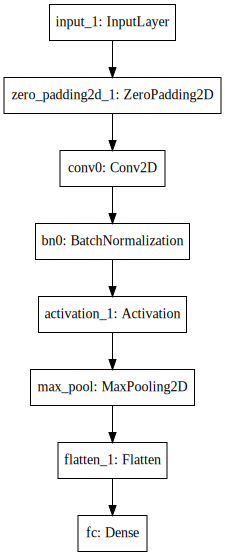

In [14]:
plot_model(happy_model, to_file='happy_model.png')
SVG(model_to_dot(happy_model).create(prog='dot', format='svg'))

In [19]:
def identify_block(X, f, filters, stage, block):
    
    '''
    input:
    X - tensor, input of the block, (samples, height, weight, channels)
    f - int, size of filter
    filters - list of int, list of filter numbers of every layer
    stage - int, for layer name
    block - str, for layer name

    output:
    X - output of the block, (samples, height, weight, channels)

    '''

    conv_name_base = f'{stage}_{block}__conv_branch__'
    bn_name_base = f'{stage}_{block}__bn_branch__'

    F1, F2, F3 = filters

    X_shortcut = X

    X = Conv2D(F1, (1, 1), name=f'{conv_name_base}main_1')(X)
    X = BatchNormalization(axis=3, name=f'{bn_name_base}main_1')(X)
    X = Activation('relu')(X)

    X = Conv2D(F2, (f, f), padding='same', name=f'{conv_name_base}main_2')(X)
    X = BatchNormalization(axis=3, name=f'{bn_name_base}main_2')(X)
    X = Activation('relu')(X)

    X = Conv2D(F3, (1, 1), name=f'{conv_name_base}main_3')(X)
    X = BatchNormalization(axis=3, name=f'{bn_name_base}main_3')(X)

    X = layers.Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X


In [20]:
def convolutional_block(X, f, s, filters, stage, block):
        
    '''
    input:
    X - tensor, input of the block, (samples, height, weight, channels)
    f - int, size of filter
    s - int, stride
    filters - list of int, list of filter numbers of every layer
    stage - int, for layer name
    block - str, for layer name

    output:
    X - output of the block, (samples, height, weight, channels)
    
    '''

    conv_name_base = f'{stage}_{block}__conv_branch__'
    bn_name_base = f'{stage}_{block}__bn_branch__'

    F1, F2, F3 = filters

    X_shortcut = X

    X = Conv2D(F1, (1, 1), strides=(s, s), name=f'{conv_name_base}main_1')(X)
    X = BatchNormalization(axis=3, name=f'{bn_name_base}main_1')(X)
    X = Activation('relu')(X)

    X = Conv2D(F2, (f, f), padding='same', name=f'{conv_name_base}main_2')(X)
    X = BatchNormalization(axis=3, name=f'{bn_name_base}main_2')(X)
    X = Activation('relu')(X)

    X = Conv2D(F3, (1, 1), name=f'{conv_name_base}main_3')(X)
    X = BatchNormalization(axis=3, name=f'{bn_name_base}main_3')(X)

    X_shortcut = Conv2D(F3, (1, 1), strides=(s, s), name=f'{conv_name_base}short_1')(X_shortcut)
    X_shortcut = BatchNormalization(axis=3, name=f'{bn_name_base}short_1')(X_shortcut)

    X = layers.Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X


In [25]:
def myResNet50(input_shape=(64, 64, 3), classes=6):

    '''
    input_shape -  A shape tuple (integer), not including the batch size.
        For instance, `shape=(32,)` indicates that the expected input
        will be batches of 32-dimensional vectors.
    '''

    X_input = Input(input_shape)

    # stage1:
    X = Conv2D(64, (7, 7), strides=(2, 2), padding='same', name='1__conv')(X_input)
    X = BatchNormalization(axis=3, name='1__bn')(X)
    X = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='1__max_pool')(X)

    # stage2:
    X = convolutional_block(X, 3, 1, [64, 64, 256], 2, 'a')
    X = identify_block(X, 3, [64, 64, 256], 2, 'b')
    X = identify_block(X, 3, [64, 64, 256], 2, 'c')

    # stage3:
    X = convolutional_block(X, 3, 2, [128, 128, 512], 3, 'a')
    X = identify_block(X, 3, [128, 128, 512], 3, 'b')
    X = identify_block(X, 3, [128, 128, 512], 3, 'c')
    X = identify_block(X, 3, [128, 128, 512], 3, 'd')

    # stage4:
    X = convolutional_block(X, 3, 2, [256, 256, 1024], 4, 'a')
    X = identify_block(X, 3, [256, 256, 1024], 4, 'b')
    X = identify_block(X, 3, [256, 256, 1024], 4, 'c')
    X = identify_block(X, 3, [256, 256, 1024], 4, 'd')
    X = identify_block(X, 3, [256, 256, 1024], 4, 'e')
    X = identify_block(X, 3, [256, 256, 1024], 4, 'f')

    # stage5:
    X = convolutional_block(X, 3, 2, [512, 512, 2048], 5, 'a')
    X = identify_block(X, 3, [256, 256, 2048], 5, 'b')
    X = identify_block(X, 3, [256, 256, 2048], 5, 'c')

    # stage6:
    X = AveragePooling2D(name='6__avg_pool')(X)
    X = Flatten(name='6__flatten')(X)
    X = Dense(classes, activation='softmax', name=f'6__fc_to{classes}')(X)

    model = Model(inputs=X_input, outputs=X, name='myResNet50')

    return model


In [26]:
mymodel = myResNet50()
mymodel.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])

In [27]:
plot_model(mymodel, to_file='mymodel.png')
#SVG(model_to_dot(mymodel).create(prog='dot', format='svg'))

In [33]:
import resnets_utils

train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes = resnets_utils.load_dataset()

In [34]:
X_train = train_set_x_orig / 255.
X_test = test_set_x_orig / 255.
Y_train = resnets_utils.convert_to_one_hot(train_set_y_orig, len(classes)).T
Y_test = resnets_utils.convert_to_one_hot(test_set_y_orig, len(classes)).T
print(f'X_train.shape = {X_train.shape}')
print(f'Y_train.shape = {Y_train.shape}')
print(f'X_test.shape = {X_test.shape}')
print(f'Y_test.shape = {Y_test.shape}')

X_train.shape = (1080, 64, 64, 3)
Y_train.shape = (1080, 6)
X_test.shape = (120, 64, 64, 3)
Y_test.shape = (120, 6)


In [35]:
mymodel.fit(X_train, Y_train, batch_size=32, epochs=10)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/10
1080/1080 [==============================] - 162s 150ms/step - loss: 1.7030 - acc: 0.4417
Epoch 2/10
1080/1080 [==============================] - 136s 126ms/step - loss: 0.6558 - acc: 0.7815
Epoch 3/10
1080/1080 [==============================] - 128s 118ms/step - loss: 0.3066 - acc: 0.9009
Epoch 4/10
1080/1080 [==============================] - 127s 118ms/step - loss: 0.2658 - acc: 0.9148
Epoch 5/10
1080/1080 [==============================] - 127s 118ms/step - loss: 0.2527 - acc: 0.9333
Epoch 6/10
1080/1080 [==============================] - 127s 117ms/step - loss: 0.3486 - acc: 0.9037
Epoch 7/10
1080/1080 [==============================] - 127s 118ms/step - loss: 0.2028 - acc: 0.9333
Epoch 8/10
1080/1080 [==============================] - 128s 118ms/step - loss: 0.0844 - acc: 0.9731
Epoch 9/10
1080/1080 [==============================] - 127s 117ms/step - loss: 0.1117 - acc: 0.96

In [36]:
predicts = mymodel.evaluate(X_test, Y_test, batch_size=32)
print(f'误差值 = {predicts[0]}')
print(f'准确度 = {predicts[1]}')

120/120 [==============================] - 8s 70ms/step
误差值 = 3.369066572189331
准确度 = 0.5583333373069763


In [45]:
print(0, np.mean(np.squeeze(test_set_y_orig) == 0))
print(1, np.mean(np.squeeze(test_set_y_orig) == 1))
print(2, np.mean(np.squeeze(test_set_y_orig) == 2))
print(3, np.mean(np.squeeze(test_set_y_orig) == 3))
print(4, np.mean(np.squeeze(test_set_y_orig) == 4))
print(5, np.mean(np.squeeze(test_set_y_orig) == 5))

0 0.16666666666666666
1 0.16666666666666666
2 0.16666666666666666
3 0.16666666666666666
4 0.16666666666666666
5 0.16666666666666666
